# Tasks:
1. Find a proper train test split
2. Implement a model for the segmentation task.
    - Find a proper loss function & explain the choice
    - Provide the implementation of the model architecture, dataloader & training method
    - Show that your implementation is working - one or two epochs are enough

3. Extend your pipeline to create a flip-robust segmentation
    - Add a second loss function, explain why this can be helpful and explain your choice
    - Add a flip augmentation
    - Show that your implementation is working - again one or two epochs are fine

About the datasets: (source : Continual Hippocampus Segmentation with Transformers)
1. Dryad: contains 50 cases of healthy patients
2. HarP: The Harmonized Hippocampal Protocol dataset, which we refer to as HarP, contains healthy subjects and patients with Alzheimer’s disease.

I will be using the Dryad dataset for this task.

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import os
import glob
import nibabel as nib
import tqdm
import torch.nn.functional as F
# from torch.autograd import Variable

### Loading the dataset

In [24]:
# Define a function to load and preprocess data for a single case
def load_and_preprocess_case(data_dir, case_name):
    # Construct the file paths for image and mask
    image_file = os.path.join(data_dir, f"{case_name}.nii.gz")
    mask_file = os.path.join(data_dir, f"{case_name}_gt.nii.gz")
    
    # Load MRI image data
    img_data = nib.load(image_file).get_fdata()

    # normalise the image
    # print(np.min(img_data), np.max(img_data))--->  0.0 100 (not normalised)
    # img_data = (img_data - np.min(img_data))/(np.max(img_data) - np.min(img_data))
    
    # Load the corresponding ground truth segmentation mask
    mask_data = nib.load(mask_file).get_fdata()
    
    return img_data, mask_data

In [25]:
# Define a function to load and preprocess the entire dataset
def load_and_preprocess_dataset(dataset_dir):
    data = []
    labels = []
    
    # Iterate through each case name
    case_names = [f"s{str(i).zfill(2)}_{hemi}" for i in range(1, 26) for hemi in ['L', 'R']]
    
    for case_name in case_names:
        img_data, mask_data = load_and_preprocess_case(dataset_dir, case_name)
        
        if img_data is not None and mask_data is not None:
            data.append(img_data)
            labels.append(mask_data)
    
    return data, labels

In [26]:
# Specify the path to the "Dryad" dataset directory
dryad_dataset_dir = 'datasets/Dryad'

# Load and preprocess the "Dryad" dataset
dryad_data, dryad_labels = load_and_preprocess_dataset(dryad_dataset_dir)

### Understanding the dataset and the MRI scans

In [27]:
# print dryad_data and dryad_labels
print(len(dryad_data))
print(len(dryad_labels))

50
50


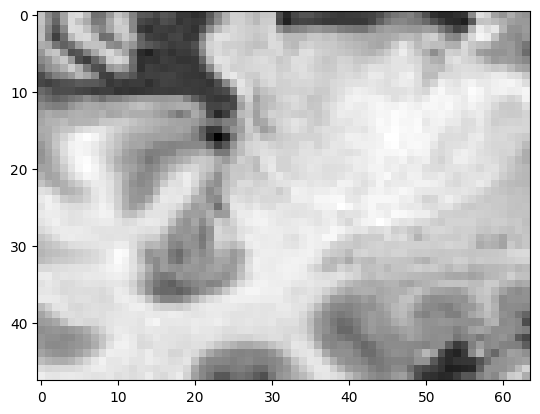

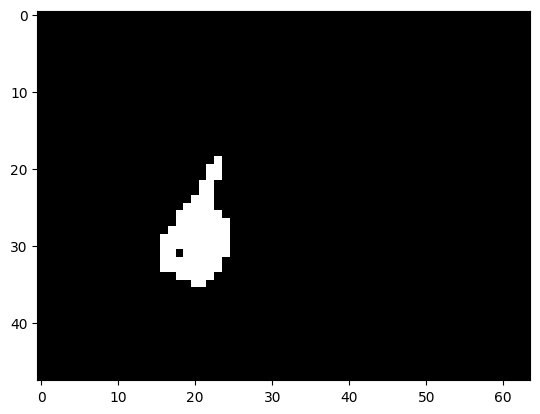

In [28]:
# visualise the images and corresponsing mask for a single case as an image
import matplotlib.pyplot as plt
plt.imshow(dryad_data[7][:,:,30], cmap='gray')
plt.show()
plt.imshow(dryad_labels[7][:,:,30], cmap='gray')
plt.show()

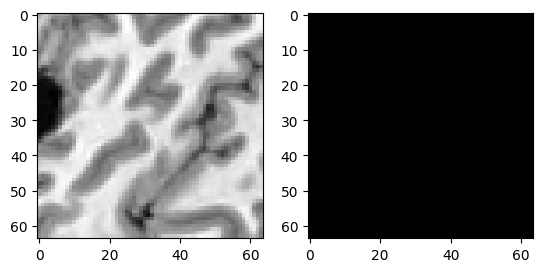

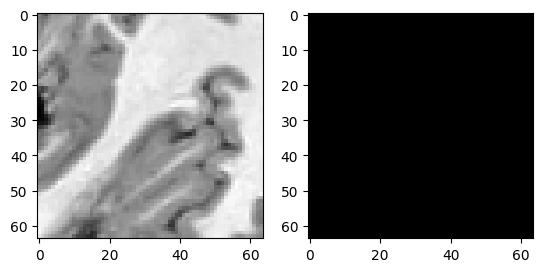

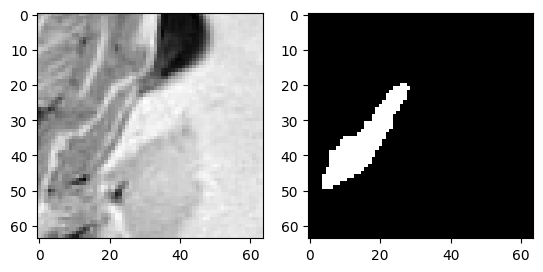

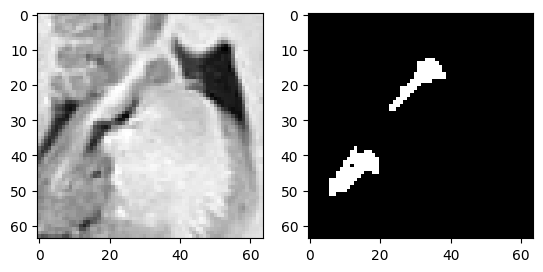

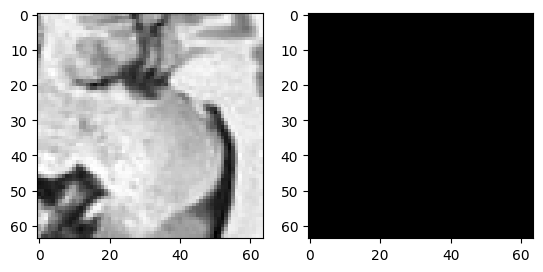

In [29]:
# Specify the range of slices you want to visualize
start_slice = 0
end_slice = 50  # Adjust this based on your data

# Loop through and display the slices and corresponding masks side by side
for slice_num in range(start_slice, end_slice,10):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(dryad_data[6][slice_num, :, :], cmap='gray')
    axarr[1].imshow(dryad_labels[6][slice_num, :, :], cmap='gray')
    plt.show()

### Implement a model for the segmentation task

In [30]:
# determining the shape of the data
print(dryad_data[0].shape)
print(dryad_labels[0].shape)

(48, 64, 64)
(48, 64, 64)


(48, 64, 64)


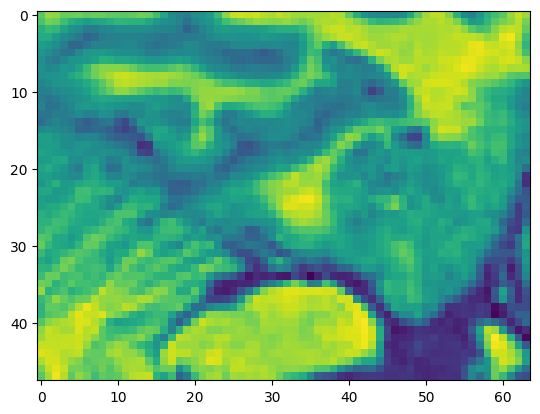

In [31]:
# Load a .nii.gz file
img = nib.load('datasets/Dryad/s01_L.nii.gz')
# Get the image data
img_data = img.get_fdata()
print(img_data.shape)   # (48,64,64)

slice1=(img_data[47,:,:,])
slice2=(img_data[:,50,:])
slice3=(img_data[:,:,10])

plt.figure()
plt.imshow(slice1)
plt.imshow(slice2)
plt.imshow(slice3)
plt.show()

In [32]:
'''DoubleConv is a custom module that defines a block with two convolutional layers followed by batch normalization and ReLU activation.
It's used to create a pair of convolutional layers with normalization and activation.'''
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
'''DownBlock is a custom module that represents the downsampling (contracting) path of the U-Net.
It consists of a DoubleConv block followed by a max-pooling operation to reduce the spatial resolution.
It takes an input tensor, applies convolution and pooling, and returns two outputs: the downsampled feature map and the original 
feature map before downsampling.'''   
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels, out_classes, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_channels, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(64 + 128, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [33]:
# Define the number of input channels and output classes
in_channels = 48  
out_classes = 48 

# Get UNet model
model = UNet(in_channels,out_classes)

In [34]:
# Define your custom dataset class for loading and preprocessing data
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'image': self.data[idx], 'mask': self.labels[idx]}

        if self.transform:
            sample = {'image': self.transform(sample['image']), 'mask': self.transform(sample['mask'])}

        return sample

In [35]:
# dice loss function
def dice_loss(predicted, target, smooth=1.0):
    # Flatten predicted and target tensors if they are PyTorch tensors
    predicted_flat = predicted.view(-1)
    target_flat = target.view(-1)

    intersection = torch.sum(predicted_flat * target_flat)
    union = torch.sum(predicted_flat) + torch.sum(target_flat)

    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)

    # Compute the Dice loss as 1 - Dice coefficient
    dice_loss = 1.0 - dice_coefficient

    return dice_loss

In [36]:
# defining the device variable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(dryad_data, dryad_labels, test_size=0.2, random_state=42)

# Create data loaders for training and testing
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=10)
test_loader = DataLoader(test_dataset, batch_size=10)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# criterion = nn.CrossEntropyLoss()  # You can use BCE loss as well
criterion = dice_loss
# criterion = FocalLoss(gamma=2, alpha=None ) 
# criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = mIoULoss()

In [37]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    batch_id = 1

    for batch in train_loader:
        inputs, masks = batch['image'].to(device).float(), batch['mask'].to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)

        outputs = F.sigmoid(outputs)
            
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}')

Epoch 1/10, Loss: 0.9465421587228775
Epoch 2/10, Loss: 0.9281781315803528
Epoch 3/10, Loss: 0.9198828786611557
Epoch 4/10, Loss: 0.9138964414596558
Epoch 5/10, Loss: 0.9087001979351044
Epoch 6/10, Loss: 0.9039867073297501
Epoch 7/10, Loss: 0.8993395268917084
Epoch 8/10, Loss: 0.8943498432636261
Epoch 9/10, Loss: 0.8888904899358749
Epoch 10/10, Loss: 0.8829369395971298


In [38]:
def visualize_results(ground_truth_mask, predicted_mask):
    plt.figure(figsize=(45,5))  # Adjust the figure size as needed

    # Plot the model output images (all 48 channels)
    for i in range(1,48,4):
        plt.subplot(3, 48, i + 49)  # 3 rows, 48 columns, position 'i + 49'
        plt.imshow(predicted_mask[i], cmap='gray')  # Assuming channels are grayscale, adjust colormap if needed
        plt.title(f'Output{i}')
        plt.axis('off')  # Turn off axis labels and ticks

    # Plot the label images (all 48 channels)
    for i in range(1,48,4):
        plt.subplot(3, 48, i + 97)  # 3 rows, 48 columns, position 'i + 97'
        plt.imshow(ground_truth_mask[i], cmap='gray')  # Assuming channels are grayscale, adjust colormap if needed
        plt.title(f'Ground Truth{i}')
        plt.axis('off')  # Turn off axis labels and ticks


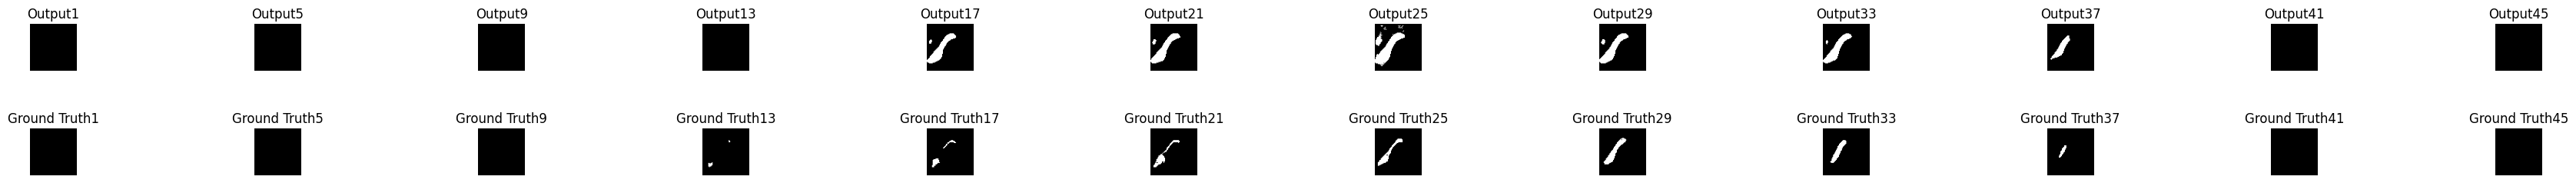

In [39]:
# Initialize the total loss
total_loss = 0.0

# Iterate through test data
for test_batch in test_loader:
    inputs = test_batch['image'].to(device).float()

    # print(inputs.shape)------> torch.Size([10, 48, 64, 64])

    # Forward pass through the model
    with torch.no_grad():  # No need to compute gradients during inference
        output = model(inputs)

    # Batch dimension
    num_images = inputs.shape[0]

    # Initialize batch loss
    batch_loss = 0.0

    for i in range(num_images):
        input_img = inputs[i]  # Get a single image from the batch

        # Calculate the Dice loss
        predicted_mask = (output[i] > 0.5).float().squeeze().cpu().numpy()
        predicted_mask_tensor = torch.tensor(predicted_mask, dtype=torch.float32)

        dice_loss_test = dice_loss(predicted_mask_tensor, test_batch['mask'][i])
        batch_loss += dice_loss_test

        # Visualise for one image in each batch
        if i == 0:
            visualize_results(test_batch['mask'][i], predicted_mask_tensor)

    # Average Dice loss for this batch
    average_loss = batch_loss / num_images

    # Accumulate the batch loss to the total loss
    total_loss += average_loss

# Calculate the average Dice loss across all batches
average_loss_across_batches = total_loss / len(test_loader)


In [40]:
print(f'Average Dice Loss on Test Set: {average_loss_across_batches}')

Average Dice Loss on Test Set: 0.5061376967817395


## Extending your pipeline to create a flip-robust segmentation
3.1 Add a second loss function, explain why this can be helpful and explain your choice

3.2 Add a flip augmentation

3.3 Show that your implementation is working - again one or two epochs are fine

In [41]:
criterion1= dice_loss
criterion2= nn.CrossEntropyLoss()

In [42]:
from torchvision import transforms

# Define data augmentation including horizontal flipping
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45) # Randomly flip horizontally
    # Add other transformations here as needed
])

# Update your CustomDataset to apply the transformations
train_dataset = CustomDataset(X_train, y_train, transform=transform)

# Rest of your training code
num_epochs = 10  # Adjust the number of epochs as needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs, masks = batch['image'].to(device).float(), batch['mask'].to(device).float()

        optimizer.zero_grad()
        outputs = model(inputs)

        outputs = F.sigmoid(outputs)

        # Apply your loss functions here (original and Dice Loss)
        loss1 = criterion1(outputs, masks)  # Original loss
        loss2 = criterion2(outputs, masks)  # Dice loss

        # Combine the losses as needed (e.g., weighted sum)
        total_loss = loss1 + loss2

        total_loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss.item()}')


Epoch 1/10, Loss: 4.78542947769165
Epoch 2/10, Loss: 4.749675750732422
Epoch 3/10, Loss: 4.7306413650512695
Epoch 4/10, Loss: 4.711769104003906
Epoch 5/10, Loss: 4.684192657470703
Epoch 6/10, Loss: 4.6691203117370605
Epoch 7/10, Loss: 4.652393341064453


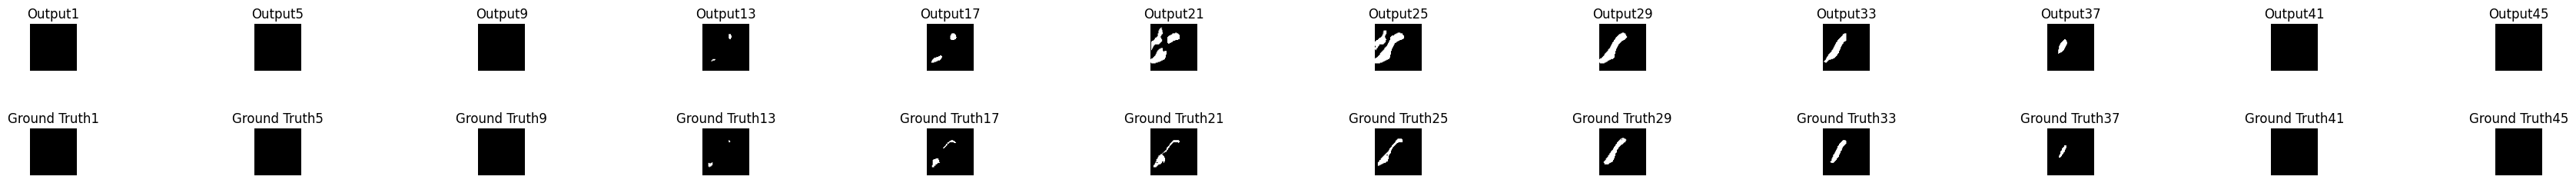

In [ ]:
# Initialize the total loss
total_loss = 0.0

# Iterate through test data
for test_batch in test_loader:
    inputs = test_batch['image'].to(device).float()

    # print(inputs.shape)------> torch.Size([10, 48, 64, 64])

    # Forward pass through the model
    with torch.no_grad():  # No need to compute gradients during inference
        output = model(inputs)

    # Batch dimension
    num_images = inputs.shape[0]

    # Initialize batch loss
    batch_loss = 0.0

    for i in range(num_images):
        input_img = inputs[i]  # Get a single image from the batch

        # Calculate the Dice loss
        predicted_mask = (output[i] > 0.5).float().squeeze().cpu().numpy()
        predicted_mask_tensor = torch.tensor(predicted_mask, dtype=torch.float32)

        dice_loss_test = dice_loss(predicted_mask_tensor, test_batch['mask'][i])
        batch_loss += dice_loss_test

        # Visualise for one image in each batch
        if i == 0:
            visualize_results(test_batch['mask'][i], predicted_mask_tensor)

    # Average Dice loss for this batch
    average_loss = batch_loss / num_images

    # Accumulate the batch loss to the total loss
    total_loss += average_loss

# Calculate the average Dice loss across all batches
average_loss_across_batches = total_loss / len(test_loader)

In [ ]:
print(f'Average Dice Loss on Test Set: {average_loss_across_batches}')

Average Dice Loss on Test Set: 0.4892085546367019
